**Fashion MNIST Veri Seti ile MLP Modeli Kullanarak Çok Sınıflı Sınıflandırma**

Fashion MNIST, çevrimiçi moda perakendecisi Zalando tarafından sağlanan ve 60.000 eğitim örneği ile 10.000 test örneğinden oluşan bir veri setidir. Her örnek, 28x28 piksel boyutunda ve gri tonlamalı bir görüntü olup, 10 farklı sınıftan birine aittir (örneğin, tişört, elbise vb.)

Bu eğitimde, her bir görüntü için giysi kategorisini tahmin etmek amacıyla, tam bağlı bir yapay sinir ağı türü olan çok katmanlı algılayıcı (MLP) modeli eğiteceğiz. Görüntüler 10 farklı kategoriden birine ait olduğu için bu bir çok sınıflı sınıflandırma problemidir. Sinir ağı modelini, Tensorflow altyapısını kullanarak Keras kütüphanesi üzerinden erişeceğiz.

In [2]:
!pip install tensorflow --upgrade --quiet

In [3]:
# gerekli kütüphanelerimizi yükleyelim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Fashion MNIST verisini yükleyelim
fashion_mnist = keras.datasets.fashion_mnist
# Veriyi eğitim ve test olarak bölelim
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Fashion MNIST etiketlerini kontrol edelim
print(np.unique(y_train))  # Eğitim etiketlerinin benzersiz değerleri
print(np.unique(y_test))   # Test etiketlerinin benzersiz değerleriC

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


**Veri Setini İnceleme ve Ön İşleme**

In [5]:
# Eğitim setinin boyutunu ve veri tipini inceleyelim
print("Eğitim Seti Boyutu: ", X_train.shape)
print("Eğitim Seti Veri Tipi: ", X_train.dtype)

Eğitim Seti Boyutu:  (60000, 28, 28)
Eğitim Seti Veri Tipi:  uint8


In [6]:
# Test setinin boyutunu ve veri tipini inceleyelim
print("Test Seti Boyutu: ", X_test.shape)
print("Test Seti Veri Tipi: ", X_test.dtype)

Test Seti Boyutu:  (10000, 28, 28)
Test Seti Veri Tipi:  uint8


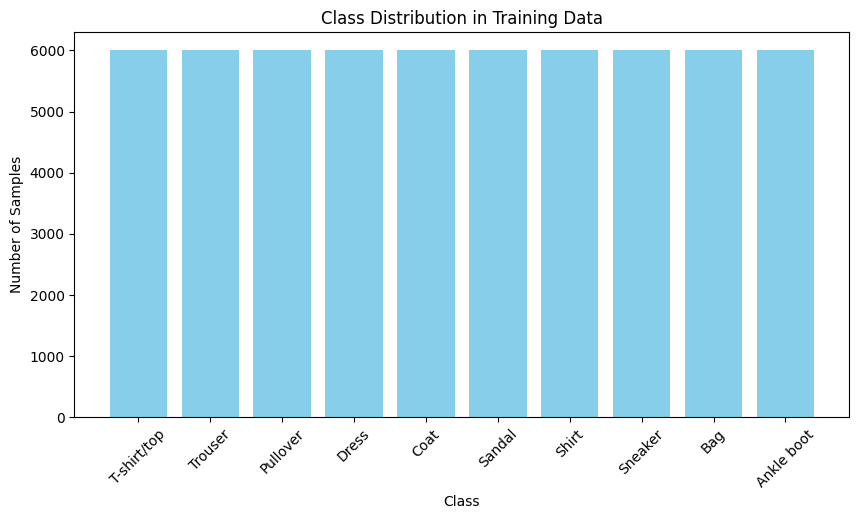

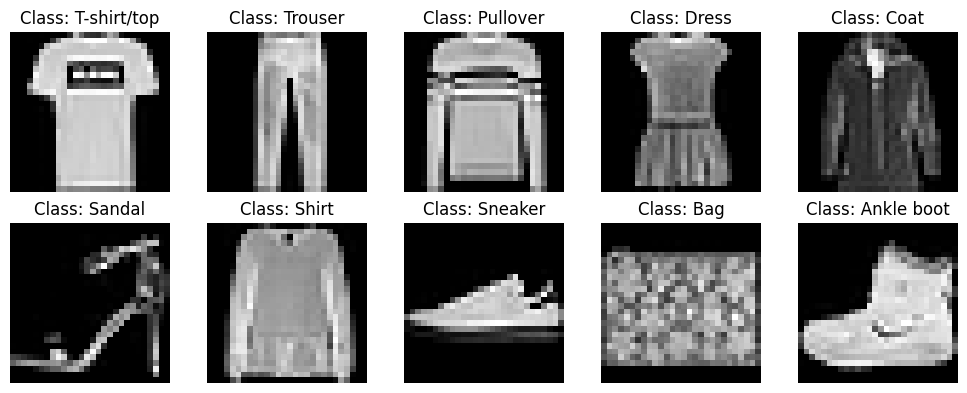

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Class distribution
class_names = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

# Sınıfların frekanslarını alalım
class_counts = [np.sum(y_train == i) for i in range(10)]

# Bar grafiği çiz
plt.figure(figsize=(10, 5))
plt.bar(class_names.values(), class_counts, color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Eğitim verisetindeki her sınıf için ilk görseli görselleştirelim
fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = X_train[y_train == i][0]
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class: {}".format(class_names[i]))
    plt.axis('off')

plt.tight_layout()
plt.show()

Veriyi modelimize uygun hale getirmek için normalleştirme işlemi yapmamız gerekiyor. Görsellerin piksel değerleri 0-255 arasında değişiyor ve bu değerleri 0-1 arasında normalize edeceğiz.

İlk kısımda eğitim verisini ve etiketlerini eğitim ve doğrulama setlerine ayırıyoruz.
İkinci kısımda ise test verisini model için uygun bir formatta kullanabilmek adına normalleştiriyoruz.

In [6]:
# Eğitim verisini ve etiketleri bölüyoruz
X_valid, X_train = X_train[:5000]/255.0, X_train[5000:]/255.0
y_valid, y_train = y_train[:5000], y_train[5000:]

In [7]:
# Test verisini de normalleştiriyoruz
X_test = X_test / 255.0

In [10]:
# X_train ve X_test üzerinde eksik veri kontrolü yapalım
missing_train = np.isnan(X_train).sum()
missing_test = np.isnan(X_test).sum()

print(f"X_train eksik veri sayısı: {missing_train}")
print(f"X_test eksik veri sayısı: {missing_test}")

X_train eksik veri sayısı: 0
X_test eksik veri sayısı: 0


In [11]:
import numpy as np

# y_train ve y_test üzerinde eksik veri kontrolü yapalım
missing_y_train = np.isnan(y_train).sum()
missing_y_test = np.isnan(y_test).sum()

print(f"y_train eksik veri sayısı: {missing_y_train}")
print(f"y_test eksik veri sayısı: {missing_y_test}")

y_train eksik veri sayısı: 0
y_test eksik veri sayısı: 0


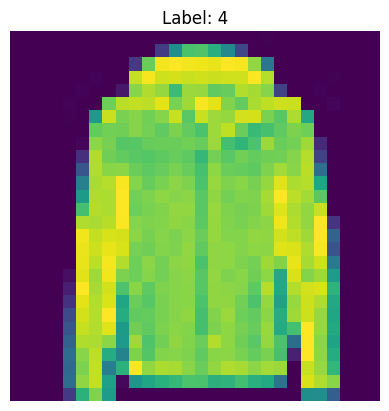

In [12]:
# Normalizasyon sonrası ilk birkaç örneği görselleştirelim
import matplotlib.pyplot as plt
%matplotlib inline
img = X_train[0]  # İlk eğitim örneğini alıyoruz
plt.imshow(img)
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [14]:
# Sınıf adlarını tanımlıyoruz
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# İlk örneği sınıf adıyla birlikte yazdıralım
print("İlk örneğin sınıf adı:", class_names[y_train[0]])

İlk örneğin sınıf adı: Coat


In [14]:
# Etiketlerin dağılımını inceleyelim
unique, counts = np.unique(y_train, return_counts=True)
print("Eğitim verisindeki etiket dağılımı:")
for label, count in zip(unique, counts):
    print(f"{class_names[label]}: {count} örnek")

Eğitim verisindeki etiket dağılımı:
T-shirt/top: 5543 örnek
Trouser: 5444 örnek
Pullover: 5496 örnek
Dress: 5499 örnek
Coat: 5512 örnek
Sandal: 5507 örnek
Shirt: 5507 örnek
Sneaker: 5488 örnek
Bag: 5510 örnek
Ankle boot: 5494 örnek


Eğitim verisinde toplam 10 sınıfımız bulunmakta.Her sınıf için yaklaşık olarak eşit sayıda örnek bulunuyor. Her sınıfın örnek sayısı 5400 ile 5500 arasında değişiyor. Bu, modelin her sınıfı yeterince öğrenebilmesi için iyi bir durumdur çünkü veri seti dengesiz olsaydı, model bazen bazı sınıfları diğerlerine göre daha iyi öğrenebilirdi diyebiliriz.

Bu tür bir denge, modelin genelleme yeteneğini artırır ve aşırı uyum (overfitting) riskini azaltabilir yorumunu yapabiliriz.

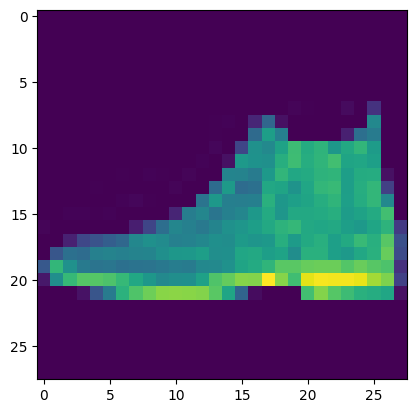

In [15]:
#Test verisetinin ilk örneğini inceleyelim.
import matplotlib.pyplot as plt
%matplotlib inline
img = X_test[0]
plt.imshow(img)

**Modelin Oluşturulması ve Yapısının Detaylı İncelenmesi**

Flatten katmanı, 28x28 boyutundaki 2D görselleri 1D vektöre dönüştürür. Görsel veriyi modelin anlayabileceği şekilde düzenler ve işlenebilir hale getirir. Bu işlem, her bir 28x28 boyutundaki görseli 784 (28x28) boyutunda bir vektöre dönüştürür. Modelin ilk adımı olan Flatten, veriyi işlemek için uygun bir formata getirir.
Dense Katmanları (İlk ve İkinci Gizli Katmanlar):

Gizli katmanlar, modelin öğrenme kapasitesini artıran yoğun (dense) katmanlardır. Her bir katman, öğrenme sürecini destekleyen nöronlar içerir.
İlk gizli katman 300 nörondan oluşur ve ReLU (Rectified Linear Unit) aktivasyon fonksiyonu kullanır. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürerek, modelin daha hızlı öğrenmesini sağlar ve aynı zamanda hesaplama açısından verimlidir.
İkinci gizli katman ise 100 nörondan oluşur ve yine ReLU fonksiyonu kullanılır. Bu katman da benzer şekilde öğrenmeyi hızlandırarak modelin karmaşıklığını arttırır. ReLU'nun sağladığı avantajlar, her iki katmanda da kullanılarak modelin daha iyi genelleme yapabilmesini sağlar.
Çıktı Katmanı:
Modelin son katmanı, 10 nörondan oluşur çünkü sınıf sayımız 10'dur (örneğin, 'Tişört/Üst', 'Pantolon', vb.). Çıktı katmanında softmax aktivasyon fonksiyonu kullanılır.
Softmax fonksiyonu, her sınıf için bir olasılık değeri üretir ve bu olasılıkların toplamı her zaman 1 olur. Model, hangi sınıfın en yüksek olasılığa sahip olduğunu tahmin eder. Softmax fonksiyonu, modelin çoklu sınıf problemlerinde hangi sınıfa ait olduğunu belirlemesini sağlar.

In [8]:
# Modelin eğitimi sırasında kullanılan rastgelelikleri kontrol etmek ve tekrarlanabilir sonuçlar elde etmektir.
# Amaç kod her çalıştırıldığında aynı sonuçların elde edilmesini sağlamak için rastgelelikleri sabitlemektir.
np.random.seed(42)  # NumPy için sabit rastgelelik
tf.random.set_seed(42)  # TensorFlow için sabit rastgelelik

In [9]:
first_model = keras.models.Sequential([
    # Görselleri düzleştiriyoruz (28x28 boyutlarındaki görüntüler 1D vektöre dönüştürülür)
    keras.layers.Flatten(input_shape=[28, 28]),  # 28x28'lik her bir görseli tek boyutlu hale getiriyoruz
    # İlk gizli katman, 300 nöron ve ReLU aktivasyon fonksiyonu kullanıyoruz
    keras.layers.Dense(300, activation='relu'),  # ReLU: Nöronun aktivasyonunu sıfır yapmaktan kaçınır
    # İkinci gizli katman, 100 nöron ve ReLU aktivasyon fonksiyonu
    keras.layers.Dense(100, activation='relu'),  # Yine ReLU fonksiyonu ile gizli katmanı oluşturuyoruz
    # Çıktı katmanı, 10 nöron (sınıf sayısı) ve softmax aktivasyon fonksiyonu
    keras.layers.Dense(10, activation='softmax')  # Softmax fonksiyonu: Sınıfların olasılıklarını hesaplar
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Modelin özetini alalım.
first_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#modelin katmanlarını (layers) görüntüleyelim.
first_model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [ ]:
#1. Gizli katmanı (hidden layer) modelin katmanlarından alalım
hidden1 = first_model.layers[1]

In [ ]:
# Gizli katmanın ismini alalım
hidden1.name

'dense'

In [ ]:
#Gizli katman ismiyle katmanı tekrar alıyoruz
layer1 = first_model.get_layer(hidden1.name)

In [ ]:
#Gizli katmandaki ağırlıkları (weights) ve bias'ları (biases) alalım
weights, biases = hidden1.get_weights()

In [ ]:
#Ağırlıkları (weights) yazdıraım
weights

array([[-0.02593391,  0.02336281, -0.00385841, ...,  0.05781651,
         0.00168605,  0.05185714],
       [-0.02574227, -0.000775  , -0.00767742, ...,  0.049225  ,
         0.03338915, -0.03716135],
       [ 0.06136279,  0.01981208,  0.00776201, ..., -0.01777833,
        -0.07251157, -0.03368261],
       ...,
       [ 0.00786823, -0.05487693, -0.06223603, ..., -0.05785093,
         0.0438983 ,  0.02185424],
       [-0.01626721, -0.02695347,  0.04996222, ..., -0.02105682,
         0.01011609, -0.06010619],
       [ 0.07118706, -0.06159338, -0.06193401, ...,  0.06069101,
         0.05789371,  0.02689169]], dtype=float32)

In [ ]:
#Bias'ların boyutunu yazdıralım
biases.shape

(300,)

In [ ]:
#Bias'ları yazdıralım
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

**Modelin Derlenmesi ve Eğitilmesi**

In [10]:
# Modelin kayıp fonksiyonu, optimizasyon algoritması ve başarı metriği belirleyelim
first_model.compile(loss='sparse_categorical_crossentropy',  # Çok sınıflı sınıflandırma için kayıp fonksiyonumuz
              optimizer = 'sgd',  # Basit Stokastik Gradyan İnişi (SGD) optimizasyon algoritması
              metrics=['accuracy'])  # Modelin doğruluğunu izlemek için 'accuracy' metriği kullanılacak

In [11]:
# Modeli eğitim verisiyle eğitelim ve doğrulama için validation verisini kullanacağız.
history = first_model.fit(X_train, y_train, epochs=30,  # Model 30 epoch boyunca eğitilecek
                    validation_data=(X_valid, y_valid))  # Doğrulama verisi ile her epoch sonrası performansı görelim

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6899 - loss: 0.9959 - val_accuracy: 0.8164 - val_loss: 0.5297
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8245 - loss: 0.5035 - val_accuracy: 0.8390 - val_loss: 0.4625
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8395 - loss: 0.4514 - val_accuracy: 0.8508 - val_loss: 0.4312
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8502 - loss: 0.4220 - val_accuracy: 0.8586 - val_loss: 0.4101
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8577 - loss: 0.4007 - val_accuracy: 0.8626 - val_loss: 0.3923
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8628 - loss: 0.3837 - val_accuracy: 0.8670 - val_loss: 0.3796
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8671 - loss: 0.3699 - val_accuracy: 0.8698 - val_loss: 0.3693
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8705 - loss: 0.3577

In [38]:
first_model.save("first_model.keras")  # modeli kaydedelim

Son epoch'ta modelin eğitim ve doğrulama (validation) performans sonuçları:
- Eğitim doğruluğu (accuracy): %91.70
- Eğitim kaybı (loss): 0.2294
- Doğrulama doğruluğu (validation accuracy): %88.80
- Doğrulama kaybı (validation loss): 0.3075


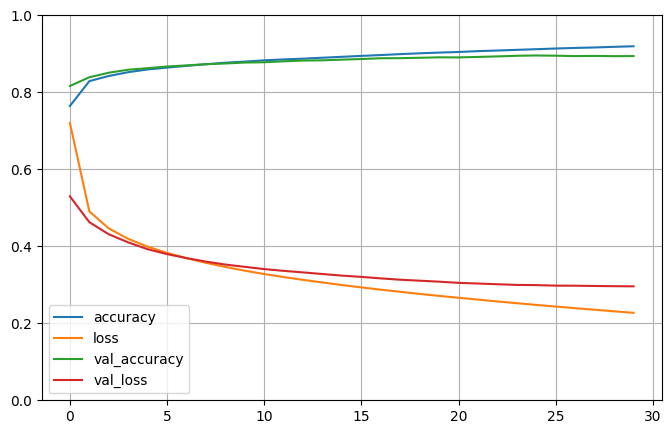

In [12]:
# Bu grafik, modelin eğitim sürecindeki doğruluk (accuracy) ve kayıp (loss) fonksiyonlarının
# epoch'lara göre nasıl değiştiğini görselleştirir.
# Bu grafik, modelin nasıl öğrenmeye devam ettiğini ve doğrulama sürecindeki ilerlemesini gözlemlememizi sağlar.

import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.show()

Grafiğe baktığımızda modelin eğitim doğruluğu oldukça yüksek, ancak doğrulama doğruluğu biraz daha düşük odluğunu görüyoruz. Bu fark, modelin eğitime biraz fazla uyum sağladığını (overfitting) gösterebilir. Eğitim kaybı düşük ancak doğrulama kaybının daha yüksek olması,modelin yeni verilere genelleme yapmada biraz zorlandığını düşündürüyor. Daha iyi genelleme için veri artırma veya düzenlileştirme (dropout, L2 regularization) gibi yöntemler uygulamayı düşünebiliriz

313/313 - 1s - 2ms/step - accuracy: 0.8797 - loss: 0.3341
Test Kayıp: 0.33413925766944885
Test Doğruluğu: 0.8797000050544739
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Precision: 0.8818729456961154
Recall: 0.8797


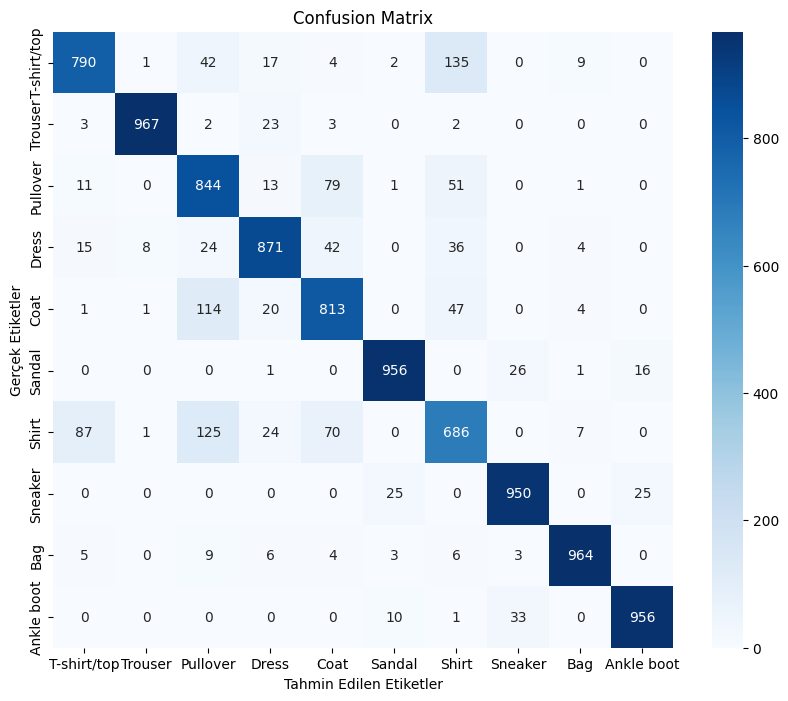

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.79      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.84      0.78      1000
       Dress       0.89      0.87      0.88      1000
        Coat       0.80      0.81      0.81      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.71      0.69      0.70      1000
     Sneaker       0.94      0.95      0.94      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [15]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim sonrası modelin doğruluğunu ve kaybını hesaplayalım
test_loss, test_acc = first_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Kayıp: {test_loss}")
print(f"Test Doğruluğu: {test_acc}")

# Precision ve Recall hesaplamaları (sınıf etiketlerinizin doğruluğunu ölçmek için)
y_pred = first_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Yalnızca sınıf etiketini alıyoruz

precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Confusion Matrix')
plt.show()

# Daha detaylı metrikler için Classification Report oluşturalım
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

**Sonuçları Değerlendirelim :**

Modelimiz çoğu sınıfı doğru tahmin etmiş, ancak bazı sınıflarda (özellikle Shirt ve Coat) performans biraz daha düşük. Bu, modelin bazı sınıfları ayırt etmekte zorlandığını gösteriyor. Trouser, Sandal, Sneaker, Bag, ve Ankle boot gibi sınıflar ise çok bir şekilde tahmin edilmiş.

**Model İyileştirme ve Optimizasyon Teknikleri**

Bu modelin performansını iyileştirmek için şu optimizasyonları ekleyelim:

**Dropout:** Aşırı öğrenmeyi (overfitting) önlemek için

**Batch Normalization:** Modelin daha hızlı ve dengeli öğrenmesini sağlamak için

**Öğrenme Oranı Değiştirme:** Adam optimizer ile farklı öğrenme oranlarını test etmek için

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
# ADAM optimizer ile modelimizi oluşturalım
second_model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
"""
import random

num_trials = 10  # 100 yerine sadece 10 rastgele deneme
best_acc = 0
best_params = {}

for _ in range(num_trials):
    lr = random.choice([0.01, 0.001, 0.0001])
    beta_1 = random.choice([0.9, 0.95, 0.99])
    beta_2 = random.choice([0.99, 0.999])
    eps = random.choice([1e-7, 1e-8])
    amsgrad = random.choice([True, False])

    print(f"Deneme: lr={lr}, beta_1={beta_1}, beta_2={beta_2}, epsilon={eps}, amsgrad={amsgrad}")

    adam_optimized_model = keras.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=eps, amsgrad=amsgrad)
    adam_optimized_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    adam_optimized_history = adam_optimized_model.fit(X_train, y_train, epochs=10,
                                                      validation_data=(X_valid, y_valid), verbose=0)

    val_acc = max(adam_optimized_history.history['val_accuracy'])
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = {'lr': lr, 'beta_1': beta_1, 'beta_2': beta_2, 'epsilon': eps, 'amsgrad': amsgrad}

print(f"\nEn iyi doğruluk: {best_acc} - En iyi parametreler: {best_params}")
"""


**Adam Optimizer ile Yapılan Denemelerin Değerlendirmesi**

Bu çalışmada, Adam optimizer için farklı parametre kombinasyonları denenmiştir. Öğrenme oranı (lr), beta_1, beta_2, epsilon ve amsgrad gibi parametreler rastgele seçilerek 10 farklı model eğitilmiştir.

**Denemeler ve Sonuçlar:**

10 farklı kombinasyon ile model eğitilmiştir ve :
En iyi doğruluk %89.64  olarak bulundu.
En iyi parametreler:
Öğrenme oranı (lr): 0.001
Beta_1: 0.9
Beta_2: 0.999
Epsilon: 1e-08
Amsgrad: True

**ADAM Optimizer Kullanalım**

In [19]:
second_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',  # SGD yerine Adam optimizer kullanalım
              metrics=['accuracy'])

In [20]:
# Modeli tekrar eğitelim
second_history = second_model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7807 - loss: 0.6104 - val_accuracy: 0.8630 - val_loss: 0.3708
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8592 - loss: 0.3782 - val_accuracy: 0.8786 - val_loss: 0.3358
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8774 - loss: 0.3341 - val_accuracy: 0.8794 - val_loss: 0.3292
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8860 - loss: 0.3059 - val_accuracy: 0.8816 - val_loss: 0.3249
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8923 - loss: 0.2846 - val_accuracy: 0.8872 - val_loss: 0.3175
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9001 - loss: 0.2670 - val_accuracy: 0.8920 - val_loss: 0.3074
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9052 - loss: 0.2530 - val_accuracy: 0.8916 - val_loss: 0.3091
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9084 - loss: 0.24

In [21]:
second_model.save("second_model.keras")

Modelin(second_model) eğitim doğruluğu daha yüksek olsa da doğrulama doğruluğunda büyük bir fark gözlemlenmiyor.
Doğrulama kaybının zamanla artması, modelin daha fazla epoch ile overfitting yapmaya başladığı yorumu yapılabilir.

313/313 - 1s - 2ms/step - accuracy: 0.8704 - loss: 0.6247
Test Kayıp: 0.6246782541275024
Test Doğruluğu: 0.8704000115394592
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.8742319415209925
Recall: 0.8704000000000001


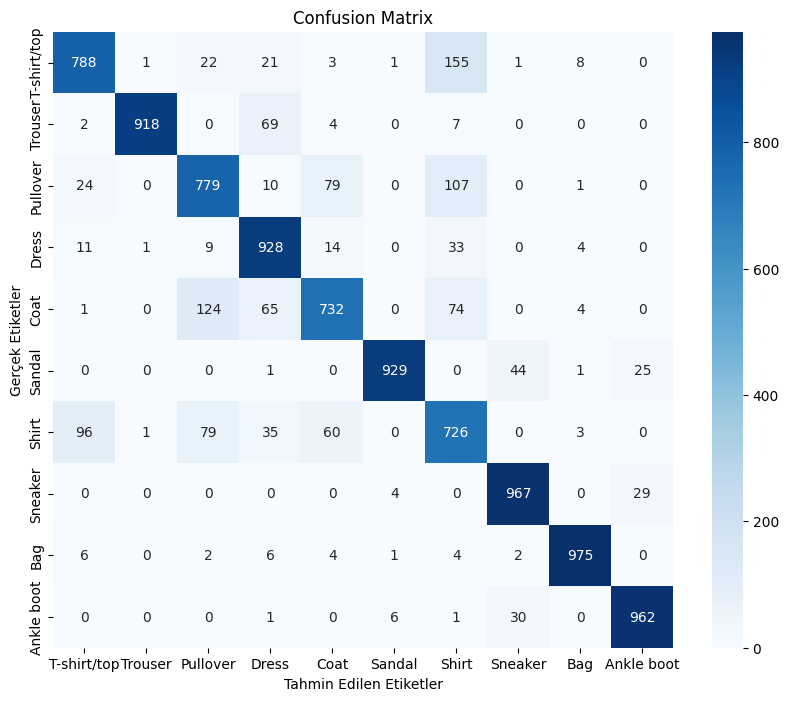

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.79      0.82      1000
     Trouser       1.00      0.92      0.96      1000
    Pullover       0.77      0.78      0.77      1000
       Dress       0.82      0.93      0.87      1000
        Coat       0.82      0.73      0.77      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.66      0.73      0.69      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [22]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim sonrası modelin doğruluğunu ve kaybını hesaplayalım
test_loss, test_acc = second_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Kayıp: {test_loss}")
print(f"Test Doğruluğu: {test_acc}")

y_pred = second_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

**SGD vs. Adam: Hangi Optimizatör Daha İyi Performans Gösterdi?**

İkinci modelde optimizer değişikliği sonrası bazı sınıflarda recall artarken, precision azalmış. Özellikle Shirt ve Pullover gibi sınıflarda, recall artırılarak daha fazla doğru tahmin yapılmaya çalışılmış ancak precision'da azalma gözlemlendi.

T-shirt/top, Sandal, Sneaker gibi sınıflarda da küçük değişiklikler olmuş.
Dress, Coat, Bag ve Ankle boot sınıflarında performans hemen hemen aynı kalmış.

Sonuç olarak, ADAM optimizer eklemek genellikle bazı sınıflarda iyileştirmeler görüldü.Modelin geneline bakıldığında, ADAM optimizer ile geliştirdiğimiz model yine de daha iyi bir performans sergiliyor ama genel doğrulukta çok büyük bir fark oluşturmadı diyebiliriz.

**Optimizer (ADAM vs SDG) Karşılaştırma**

In [23]:
# Adam optimizer ile eğitilmiş model
adam_test_loss, adam_test_acc = second_model.evaluate(X_test, y_test, verbose=2)
adam_y_pred = second_model.predict(X_test)
adam_y_pred_classes = np.argmax(adam_y_pred, axis=1)

# Precision ve Recall hesaplamaları (Adam optimizer için)
adam_precision = precision_score(y_test, adam_y_pred_classes, average='macro')
adam_recall = recall_score(y_test, adam_y_pred_classes, average='macro')

# Sonuçları yazdır
print(f"Adam Optimizer - Test Kayıp: {adam_test_loss}")
print(f"Adam Optimizer - Test Doğruluğu: {adam_test_acc}")
print(f"Adam Optimizer - Precision: {adam_precision}")
print(f"Adam Optimizer - Recall: {adam_recall}")

# SG'de optimizerli model
sgd_test_loss, sgd_test_acc = first_model.evaluate(X_test, y_test, verbose=2)
sgd_y_pred = first_model.predict(X_test)
sgd_y_pred_classes = np.argmax(sgd_y_pred, axis=1)

# Precision ve Recall hesaplamaları (SGD optimizer için)
sgd_precision = precision_score(y_test, sgd_y_pred_classes, average='macro')
sgd_recall = recall_score(y_test, sgd_y_pred_classes, average='macro')

# Sonuçları yazdır
print(f"SGD Optimizer - Test Kayıp: {sgd_test_loss}")
print(f"SGD Optimizer - Test Doğruluğu: {sgd_test_acc}")
print(f"SGD Optimizer - Precision: {sgd_precision}")
print(f"SGD Optimizer - Recall: {sgd_recall}")

313/313 - 1s - 2ms/step - accuracy: 0.8704 - loss: 0.6247
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Adam Optimizer - Test Kayıp: 0.6246782541275024
Adam Optimizer - Test Doğruluğu: 0.8704000115394592
Adam Optimizer - Precision: 0.8742319415209925
Adam Optimizer - Recall: 0.8704000000000001
313/313 - 1s - 2ms/step - accuracy: 0.8797 - loss: 0.3341
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SGD Optimizer - Test Kayıp: 0.33413925766944885
SGD Optimizer - Test Doğruluğu: 0.8797000050544739
SGD Optimizer - Precision: 0.8818729456961154
SGD Optimizer - Recall: 0.8797


313/313 - 1s - 3ms/step - accuracy: 0.8850 - loss: 0.5036
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 - 1s - 2ms/step - accuracy: 0.8799 - loss: 0.3427
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Adam Optimizer - Test Kayıp: 0.5036315321922302
Adam Optimizer - Test Doğruluğu: 0.8849999904632568
Adam Optimizer - Precision: 0.8847399491962571
Adam Optimizer - Recall: 0.885
SGD Optimizer - Test Kayıp: 0.34273332357406616
SGD Optimizer - Test Doğruluğu: 0.8798999786376953
SGD Optimizer - Precision: 0.8827560296609629
SGD Optimizer - Recall: 0.8798999999999999


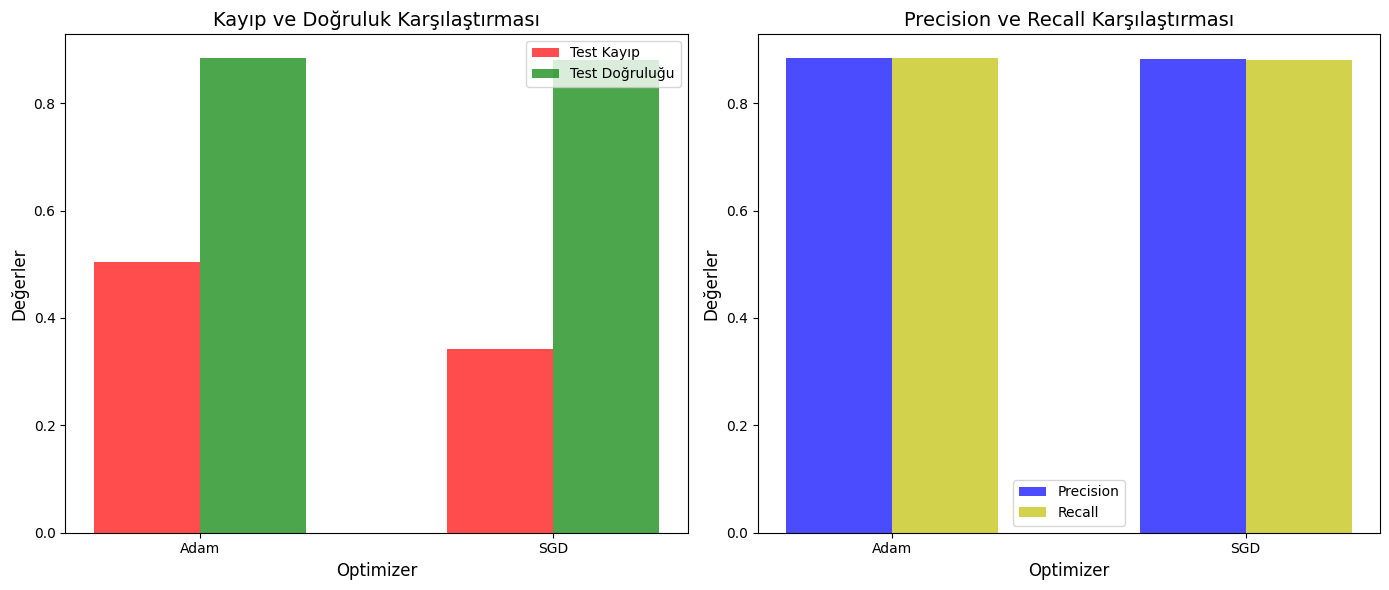

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Adam optimizer ile eğitilmiş model
adam_test_loss, adam_test_acc = second_model.evaluate(X_test, y_test, verbose=2)
adam_y_pred = second_model.predict(X_test)
adam_y_pred_classes = np.argmax(adam_y_pred, axis=1)

# Precision ve Recall hesaplamaları (Adam optimizer için)
adam_precision = precision_score(y_test, adam_y_pred_classes, average='macro')
adam_recall = recall_score(y_test, adam_y_pred_classes, average='macro')

# SGD optimizerli model
sgd_test_loss, sgd_test_acc = first_model.evaluate(X_test, y_test, verbose=2)
sgd_y_pred = first_model.predict(X_test)
sgd_y_pred_classes = np.argmax(sgd_y_pred, axis=1)

# Precision ve Recall hesaplamaları (SGD optimizer için)
sgd_precision = precision_score(y_test, sgd_y_pred_classes, average='macro')
sgd_recall = recall_score(y_test, sgd_y_pred_classes, average='macro')

# Sonuçları yazdır
print(f"Adam Optimizer - Test Kayıp: {adam_test_loss}")
print(f"Adam Optimizer - Test Doğruluğu: {adam_test_acc}")
print(f"Adam Optimizer - Precision: {adam_precision}")
print(f"Adam Optimizer - Recall: {adam_recall}")
print(f"SGD Optimizer - Test Kayıp: {sgd_test_loss}")
print(f"SGD Optimizer - Test Doğruluğu: {sgd_test_acc}")
print(f"SGD Optimizer - Precision: {sgd_precision}")
print(f"SGD Optimizer - Recall: {sgd_recall}")

# Grafik oluşturma
labels = ['Adam', 'SGD']

# Kayıp ve doğruluk
test_loss = [adam_test_loss, sgd_test_loss]
test_acc = [adam_test_acc, sgd_test_acc]

# Precision ve Recall
precisions = [adam_precision, sgd_precision]
recalls = [adam_recall, sgd_recall]

# Grafik Boyutu
plt.figure(figsize=(14, 6))

# Kayıp ve Doğruluk Grafiği
plt.subplot(1, 2, 1)
bar_width = 0.3
index = np.arange(len(labels))

plt.bar(index, test_loss, bar_width, label='Test Kayıp', color='r', alpha=0.7)
plt.bar(index + bar_width, test_acc, bar_width, label='Test Doğruluğu', color='g', alpha=0.7)

plt.xlabel('Optimizer', fontsize=12)
plt.ylabel('Değerler', fontsize=12)
plt.title('Kayıp ve Doğruluk Karşılaştırması', fontsize=14)
plt.xticks(index + bar_width / 2, labels)
plt.legend()

# Precision ve Recall Grafiği
plt.subplot(1, 2, 2)
bar_width = 0.3

plt.bar(index, precisions, bar_width, label='Precision', color='b', alpha=0.7)
plt.bar(index + bar_width, recalls, bar_width, label='Recall', color='y', alpha=0.7)

plt.xlabel('Optimizer', fontsize=12)
plt.ylabel('Değerler', fontsize=12)
plt.title('Precision ve Recall Karşılaştırması', fontsize=14)
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()

**ADAM Optimizer vs SDG Optimizer**

Adam optimizer, doğruluk, precision ve recall açısından biraz daha iyi performans gösterirken, SGD optimizer test kaybı açısından daha iyi bir sonuç veriyor, yani hata oranı daha düşük.
İki optimizer de genel olarak benzer performans sergiliyor ve aralarındaki farklar çok büyük değil diyebiliriz.

Adam optimizer genellikle daha hızlı, SGD ise daha yavaş ancak daha kararlı bir öğrenme süreci sunuyor. Ancak hızlı öğrenme için Adam optimizer'ı tercih edeceğiz.

**ADAM optimizer 0.001 ve 0.005 değerleri için performansları gözlemleyelim**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np

# Farklı learning rate değerlerini belirleyelim
learning_rates = [0.0001, 0.001, 0.005, 0.01]

# Sonuçları saklayacağımız bir liste
results = []

# Eğitim verisini kullanarak her learning rate için modeli eğitelim
for lr in learning_rates:
    print(f"Training with learning rate = {lr}")

    # Modeli oluşturalım
    lr_model = keras.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    # Adam optimizer ile compile edelim
    optimizer = Adam(learning_rate=lr)
    lr_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Modeli eğitelim
    lr_history = lr_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=1)

    # Son epoch'taki doğruluk değerini kaydedelim
    final_val_acc = lr_history.history['val_accuracy'][-1]
    results.append((lr, final_val_acc))

# En iyi learning rate'i bulalım
best_lr, best_acc = max(results, key=lambda x: x[1])
print(f"\nEn iyi learning rate: {best_lr} - Validation Accuracy: {best_acc:.4f}")

Training with learning rate = 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7198 - loss: 0.8813 - val_accuracy: 0.8516 - val_loss: 0.4326
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8484 - loss: 0.4313 - val_accuracy: 0.8632 - val_loss: 0.3893
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8636 - loss: 0.3856 - val_accuracy: 0.8718 - val_loss: 0.3665
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8728 - loss: 0.3578 - val_accuracy: 0.8758 - val_loss: 0.3504
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8797 - loss: 0.3379 - val_accuracy: 0.8796 - val_loss: 0.3402
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8835 - loss: 0.3221 - val_accuracy: 0.8826 - val_loss: 0.3317
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8873 - loss: 0.3089 - val_accuracy: 0.8842 - val_loss: 0.3252
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8923 - loss: 0.2

In [ ]:
lr_model.save("lr_model.keras")

En iyi learning rate: 0.001 - Validation Accuracy: 0.8914

**Dropout ile Model Performansını Artırma: Test Sonuçları ve Kıyaslama**

"second_model" mizde overfitting olabileceği yorumunda bulunmuştuk. Bu modelimize Dropout tekniği kullanacağız.

Modelin doğruluğunu artırmak ve **aşırı öğrenme (overfitting) problemini engellemek amacıyla Dropout tekniğini** kullanacağız. Dropout, modelin eğitim sürecinde bazı nöronları rastgele kapatarak her adımda farklı bir ağırlık güncellemesi yapar. Bu sayede modelin, eğitim verilerine aşırı uyum sağlaması engellenir ve genelleme yeteneği artırılır

Overfitting analizi yapabilmek için hem eğitim hem doğrulama kayıplarını ve doğruluklarını ayrıca en iyi Dropout oranını belirlemek için en yüksek doğrulama doğruluğuna sahip oranı tespit edip grafikle çizdireceğiz.

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

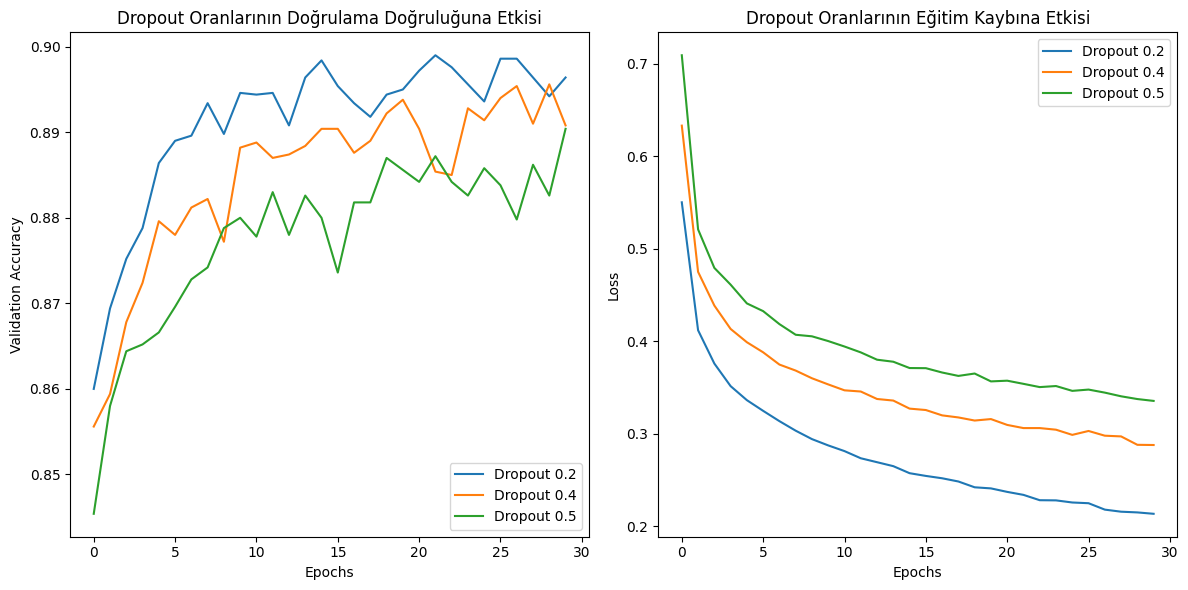

En iyi Dropout oranı: 0.2 (Validation Accuracy: 0.8990)


In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dropout oranları
dropout_rates = [0.2, 0.4, 0.5]
history_dict = {}

# Her Dropout oranı için model oluşturalım ve eğitelim
for rate in dropout_rates:
    second_model_dropout = Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(300, activation='relu'),
        layers.Dropout(rate),  # Dropout ekleyelim
        layers.Dense(100, activation='relu'),
        layers.Dropout(rate),  # Dropout ekleyelim
        layers.Dense(10, activation='softmax')
    ])

    # Modeli derleyelim
    second_model_dropout.compile(optimizer=Adam(learning_rate=0.001),
                                 loss="sparse_categorical_crossentropy",
                                 metrics=["accuracy"])

    # Modeli eğitelim
    second_model_dropout_history = second_model_dropout.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)

    # Eğitim ve doğrulama doğruluğunu kaydedelim
    history_dict[rate] = second_model_dropout_history.history  # geçmişi kaydedelim

# Grafikleri çizelim
plt.figure(figsize=(12, 6))

# Doğrulama doğruluğu grafiği
plt.subplot(1, 2, 1)
for rate in dropout_rates:
    plt.plot(history_dict[rate]['val_accuracy'], label=f'Dropout {rate}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Dropout Oranlarının Doğrulama Doğruluğuna Etkisi')
plt.legend()

# Eğitim kaybı grafiği
plt.subplot(1, 2, 2)
for rate in dropout_rates:
    plt.plot(history_dict[rate]['loss'], label=f'Dropout {rate}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dropout Oranlarının Eğitim Kaybına Etkisi')
plt.legend()

plt.tight_layout()
plt.show()

# En iyi Dropout oranını ve doğruluğunu yazdıralım
best_dropout = max(history_dict, key=lambda x: max(history_dict[x]['val_accuracy']))
best_val_acc = max(history_dict[best_dropout]['val_accuracy'])
print(f"En iyi Dropout oranı: {best_dropout} (Validation Accuracy: {best_val_acc:.4f})")

 Grafiğe baktığınızda, dropout 0.2'nin validation doğruluğunu artırdığını ve 0.4 ve 0.5'e göre daha iyi performans gösterdiğini söyleyebiliriz.

In [27]:
second_model_dropout.save("second_model_dropout.keras")  # modelkaydediyor

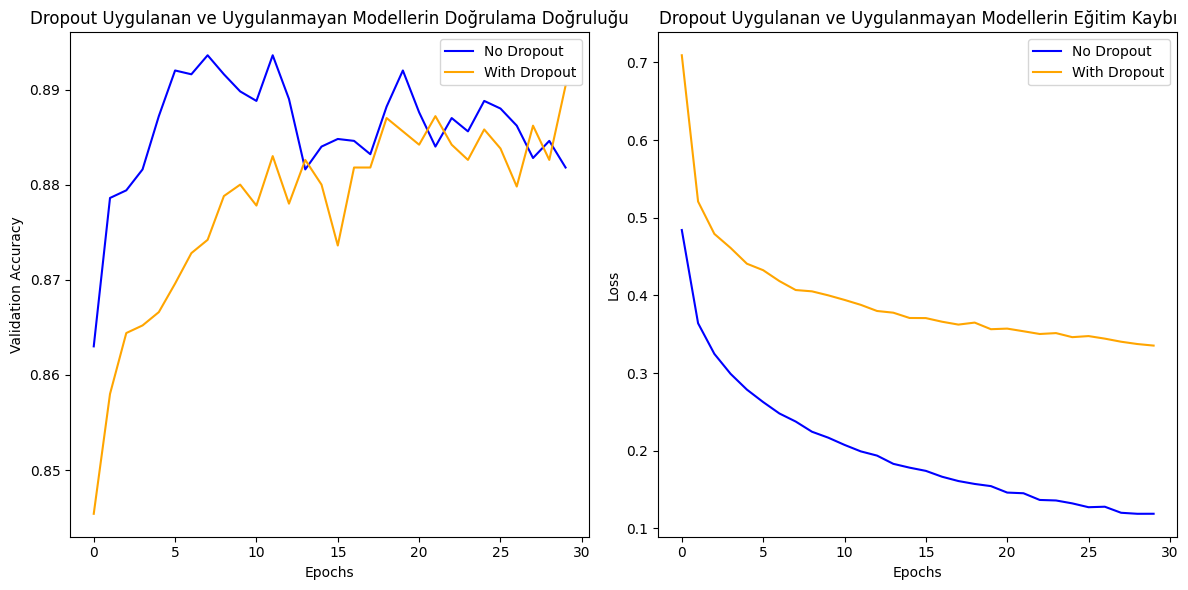

Dropout olmayan modelin en son doğrulama doğruluğu: 0.8818
Dropout'lu modelin en son doğrulama doğruluğu: 0.8904
Dropout olmayan modelin en son kaybı: 0.1189
Dropout'lu modelin en son kaybı: 0.3354


In [28]:
import matplotlib.pyplot as plt

# Dropout uygulanmış ve uygulanmamış modellerin eğitim geçmişlerini kaydedelim
history_dict = {}

# Dropout olmayan model (second_model)
history_dict['no_dropout'] = second_history.history

# Dropout'lu model (second_model_dropout)
history_dict['dropout'] = second_model_dropout_history.history

# Grafikleri çizelim
plt.figure(figsize=(12, 6))

# 1. Grafik: Doğrulama doğruluğu karşılaştırması
plt.subplot(1, 2, 1)
plt.plot(history_dict['no_dropout']['val_accuracy'], label='No Dropout', color='blue')
plt.plot(history_dict['dropout']['val_accuracy'], label='With Dropout', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Dropout Uygulanan ve Uygulanmayan Modellerin Doğrulama Doğruluğu')
plt.legend()

# 2. Grafik: Eğitim kaybı karşılaştırması
plt.subplot(1, 2, 2)
plt.plot(history_dict['no_dropout']['loss'], label='No Dropout', color='blue')
plt.plot(history_dict['dropout']['loss'], label='With Dropout', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dropout Uygulanan ve Uygulanmayan Modellerin Eğitim Kaybı')
plt.legend()

plt.tight_layout()
plt.show()

# Sonuçları yazdırma
final_val_acc_no_dropout = history_dict['no_dropout']['val_accuracy'][-1]
final_val_acc_with_dropout = history_dict['dropout']['val_accuracy'][-1]
final_loss_no_dropout = history_dict['no_dropout']['loss'][-1]
final_loss_with_dropout = history_dict['dropout']['loss'][-1]

print(f"Dropout olmayan modelin en son doğrulama doğruluğu: {final_val_acc_no_dropout:.4f}")
print(f"Dropout'lu modelin en son doğrulama doğruluğu: {final_val_acc_with_dropout:.4f}")

print(f"Dropout olmayan modelin en son kaybı: {final_loss_no_dropout:.4f}")
print(f"Dropout'lu modelin en son kaybı: {final_loss_with_dropout:.4f}")

Dropout tekniği kullandığımız model, doğrulama doğruluğu açısından biraz daha iyi performans göstermiş. Ancak fark çok küçük. Bu da Dropout'un gerçekten modelin genelleme yeteneğini biraz daha artırdığını gösteriyor. Yine de doğrulama doğruluğu açısından, Dropout'un modelin performansına çok büyük bir etkisi olmadığını söyleyebiliriz.

Burada dikkat çeken önemli bir fark var. Dropout'lu modelin eğitim kaybı çok daha yüksek görülüyor. Bu, Dropout'un modelin öğrenmesini daha zorlaştırdığı anlamına geliyor. Ancak bu durum, modelin overfitting'i önlemek adına önemli bir gösterge olabilir. Dropout, eğitim verisine aşırı uyum sağlamayı engellemeye çalışır, dolayısıyla eğitim kaybı yüksek olsa da bu, genelleme açısından faydalı olduğu yorumunu yapabiliriz.

Sonuç olarak,
Dropout'lu model doğrulama doğruluğunda biraz daha iyi performans gösterse de, eğitim kaybı çok daha yüksek. Bu, Dropout'un eğitim sırasında modelin bazı bilgilerden "feragat" etmesine neden olduğunu düşündürüyor. Yinede overfitting'i engelleme konusunda faydalı olduğunu söyleyebiliriz.

Dropout'lu model daha genellenebilir bir model olarak görünmekte, ancak eğitimi daha zorlaştırdığı için zaman ve optimizasyon gerektiriyor. Eğer overfitting'i engellemeye çalışıyorsanız, Dropout'lu modeli tercih etmek mantıklı olacaktır.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

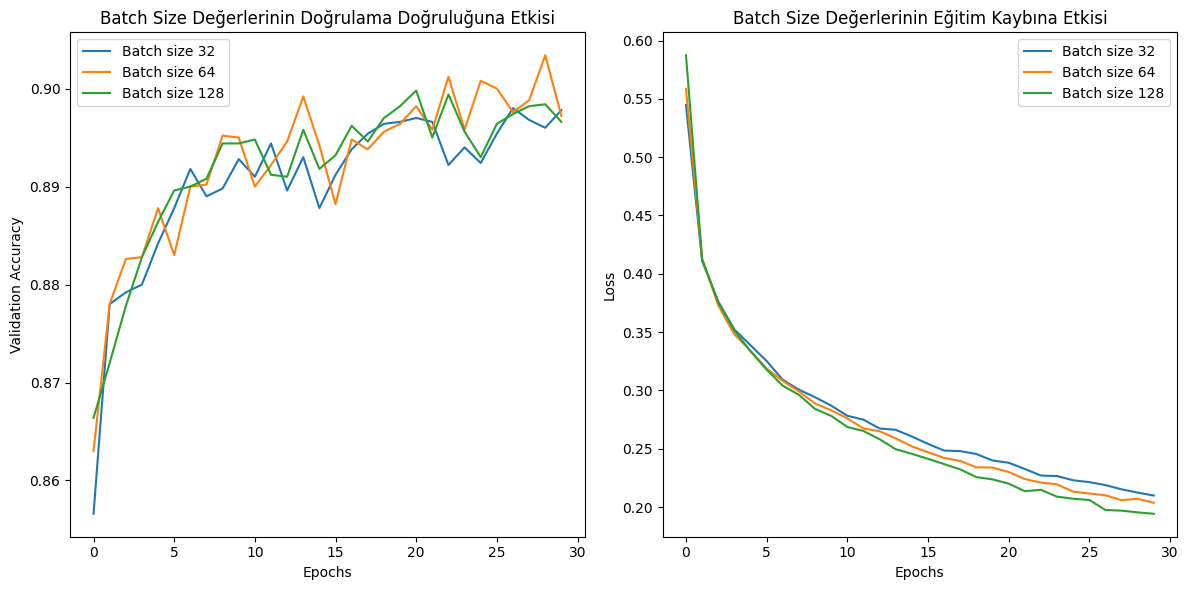

Batch size 32:
  En son doğrulama doğruluğu: 0.8978
  En son kayıp: 0.2099

Batch size 64:
  En son doğrulama doğruluğu: 0.8972
  En son kayıp: 0.2036

Batch size 128:
  En son doğrulama doğruluğu: 0.8966
  En son kayıp: 0.1942



In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Batch size'lar ve Dropout oranı
batch_sizes = [32, 64, 128]
dropout_rate = 0.2
history_dict = {}

# Her Batch size için model oluşturup eğitelim
for batch_size in batch_sizes:
    batch_model = Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(300, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(100, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    # Modeli derleyelim
    batch_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # Modeli eğitelim
    batch_history = batch_model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    # Eğitim ve doğrulama doğruluğunu kaydedelim
    history_dict[batch_size] = batch_history.history

# Grafikleri çizelim
plt.figure(figsize=(12, 6))

# Doğrulama doğruluğu grafiği
plt.subplot(1, 2, 1)
for batch_size in batch_sizes:
    plt.plot(history_dict[batch_size]['val_accuracy'], label=f'Batch size {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Batch Size Değerlerinin Doğrulama Doğruluğuna Etkisi')
plt.legend()

# Eğitim kaybı grafiği
plt.subplot(1, 2, 2)
for batch_size in batch_sizes:
    plt.plot(history_dict[batch_size]['loss'], label=f'Batch size {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Batch Size Değerlerinin Eğitim Kaybına Etkisi')
plt.legend()

plt.tight_layout()
plt.show()

# Sonuçları yazdıralım
for batch_size in batch_sizes:
    final_val_acc = history_dict[batch_size]['val_accuracy'][-1]
    final_loss = history_dict[batch_size]['loss'][-1]
    print(f"Batch size {batch_size}:")
    print(f"  En son doğrulama doğruluğu: {final_val_acc:.4f}")
    print(f"  En son kayıp: {final_loss:.4f}")
    print()

In [31]:
batch_model.save("batch_model.keras")

Modelin performansını değerlendirirken, doğrulama doğruluğu ve kayıp arasındaki dengeyi göz önünde bulundurmak önemlidir. Yapılan deneylerde, **batch size 64, doğrulama doğruluğu ve kayıp arasında daha tutarlı ve dengeli sonuçlar sunmaktadır.** Batch size 32 ile en yüksek doğrulama doğruluğunu elde etmemize rağmen, kayıp değeri biraz daha yüksek çıkmaktadır, bu da modelin genelleme yeteneğini olumsuz etkileyebilir. Öte yandan, batch size 128 ile kayıp değeri düşerken doğrulama doğruluğunda küçük bir azalma gözlemlenmiştir.

Batch size 64, hem doğrulama doğruluğunu yüksek tutarak hem de kaybı düşük tutarak daha **dengeli bir performans sergilemektedir**. Bu nedenle, modelin doğruluğunu ve genelleme kabiliyetini optimize etmek için batch size 64’ün daha uygun bir seçenek olduğunu düşünüyorum.

----------------------------

**BatchNormalization**

Batch Normalization, derin öğrenme modellerinde eğitim sırasında ortaya çıkan gradyan kaybolması veya gradyan patlaması gibi sorunları azaltmak için kullanılan bir tekniktir.

Bu işlemi, her katmanın çıktısını normalize ederek, öğrenme sürecinin daha hızlı ve stabil olmasını sağlaması için kullanacağız.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

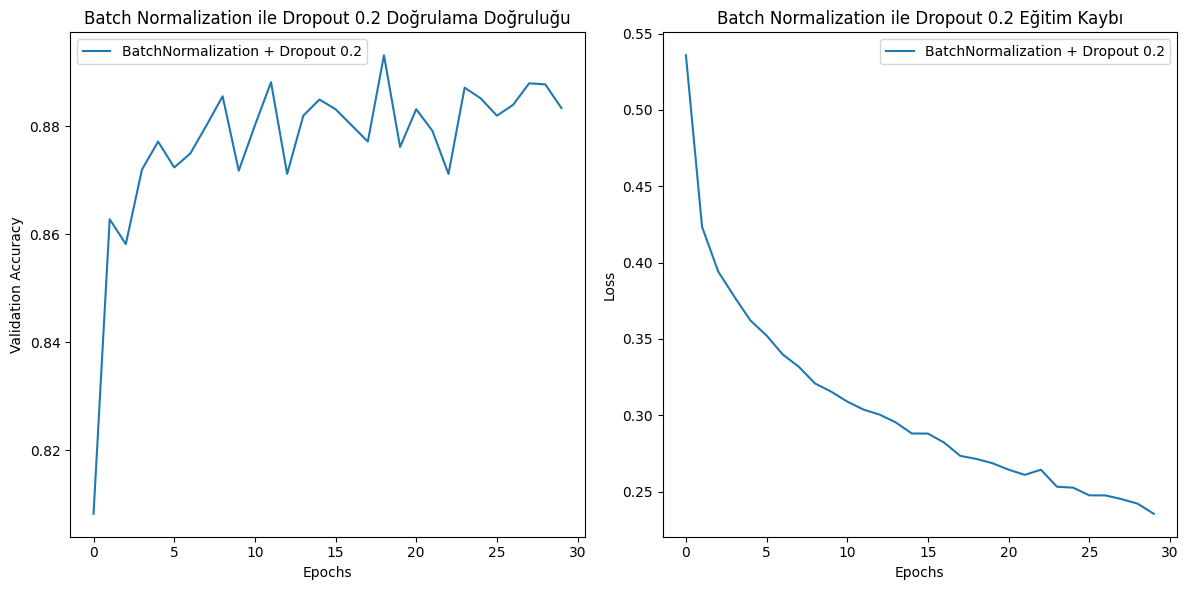

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

# Batch size 64, Dropout 0.2 ve Batch Normalization ile model
model_with_bn = Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation='relu'),
    layers.BatchNormalization(),  # Batch Normalization ekliyoruz
    layers.Dropout(0.2),  # Dropout ekliyoruz
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),  # Batch Normalization ekliyoruz
    layers.Dropout(0.2),  # Dropout ekliyoruz
    layers.Dense(10, activation='softmax')
])


model_with_bn.compile(optimizer=Adam(learning_rate=0.001),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])


history_bn = model_with_bn.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=64, verbose=0)


history_dict_bn = history_bn.history

# Grafikleri çizme
plt.figure(figsize=(12, 6))

# Doğrulama doğruluğu grafiği
plt.subplot(1, 2, 1)
plt.plot(history_dict_bn['val_accuracy'], label='BatchNormalization + Dropout 0.2')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Batch Normalization ile Dropout 0.2 Doğrulama Doğruluğu')
plt.legend()

# Eğitim kaybı grafiği
plt.subplot(1, 2, 2)
plt.plot(history_dict_bn['loss'], label='BatchNormalization + Dropout 0.2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Batch Normalization ile Dropout 0.2 Eğitim Kaybı')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
model_with_bn.save("model_with_bn.keras")

**Dropout ve Batch Normalization uygulanarak eğitilen modelin performansını değerlendireceğiz.**

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


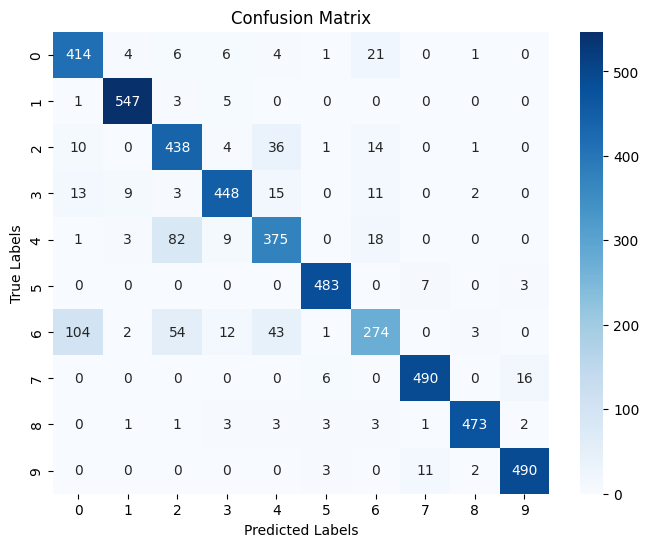

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       457
           1       0.97      0.98      0.98       556
           2       0.75      0.87      0.80       504
           3       0.92      0.89      0.91       501
           4       0.79      0.77      0.78       488
           5       0.97      0.98      0.97       493
           6       0.80      0.56      0.66       493
           7       0.96      0.96      0.96       512
           8       0.98      0.97      0.97       490
           9       0.96      0.97      0.96       506

    accuracy                           0.89      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.89      0.88      5000



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Modeli derleyip eğitelim
model_with_bn.compile(optimizer=Adam(learning_rate=0.001),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

# Modeli eğitelim
history_bn = model_with_bn.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=64, verbose=0)

# Tahminler yapalım
y_pred = model_with_bn.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılığı tahmin et

# Confusion Matrix oluşturuyoruz
cm = confusion_matrix(y_valid, y_pred_classes)

# Confusion Matrix görselleştiriyoruz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_valid, y_pred_classes))

-------------------------

**Modelin Performansını Değerlendirelim**

Sınıf Başarısı:

Model, özellikle sınıf 1 (Trouse) ve sınıf 5 (Sandal) için çok iyi sonuçlar elde etti. Bu sınıflarda precision, recall ve f1-score oldukça yüksek (yaklaşık 0.97-0.98), bu da modelin bu sınıfları doğru şekilde tahmin ettiğini gösteriyor.
Sınıf 7 (Sneaker) de yüksek performans gösteren bir diğer sınıf olup, precision ve recall değeri 0.96 civarlarında, bu da modelin bu sınıfı çok başarılı bir şekilde sınıflandırdığını gösteriyor.
Sınıf 6 (Shirt) ise daha düşük performans sergileyen bir sınıf. precision 0.80, ancak recall 0.56 gibi düşük bir değer elde edildi. Bu, modelin sınıf 6'ya ait örnekleri yeterince iyi sınıflandıramadığını gösteriyor diyebilriz.
Sınıf 4 (Coat) ise biraz daha düşük performans gösteriyor. precision 0.79, ancak recall 0.77 olarak ölçülmüş. Bu da modelin bu sınıfla ilgili bazı hatalı sınıflandırmalar yapabileceğini düşündürüyor.

Genel Performans:

Genel doğruluk (accuracy) 0.89 olarak hesaplanmıştır. Bu, modelin doğru sınıflandırma oranının %89 olduğunu gösteriyor. Bu oran oldukça yüksek bir başarı olarak değerlendirilebilir.

Sonuç olarak:
Model, genel olarak iyi bir performans sergiliyor, özellikle bazı sınıflar için mükemmel sonuçlar elde edildi. Ancak sınıf 6 ve 4 için daha fazla iyileştirme yapılabilir. Modellerin performansını artırmak için veri artırma teknikleri veya daha fazla hiperparametre optimizasyonu gibi yöntemler düşünebiliriz.

**İlk modelimiz (first_model) ile optimizasyon ve iyileştirmeler yaptığımız son modelimizi (model_with_bn) karşılaştıralım**

In [44]:
# Eğitim sırasında history objesini kaydetme
history_model_with_bn = model_with_bn.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
history_first_model = first_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

# History objelerini kaydetmek
model_with_bn_history = history_model_with_bn.history
first_model_history = history_first_model.history

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9101 - loss: 0.2414 - val_accuracy: 0.8848 - val_loss: 0.3271
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9050 - loss: 0.2486 - val_accuracy: 0.8904 - val_loss: 0.3219
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9090 - loss: 0.2463 - val_accuracy: 0.8952 - val_loss: 0.2999
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9107 - loss: 0.2409 - val_accuracy: 0.8914 - val_loss: 0.3160
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9098 - loss: 0.2408 - val_accuracy: 0.8946 - val_loss: 0.3145
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9120 - loss: 0.2389 - val_accuracy: 0.8978 - val_loss: 0.3005
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9107 - loss: 0.2397 - val_accuracy: 0.8880 - val_loss: 0.3238
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9065 - loss: 0.245

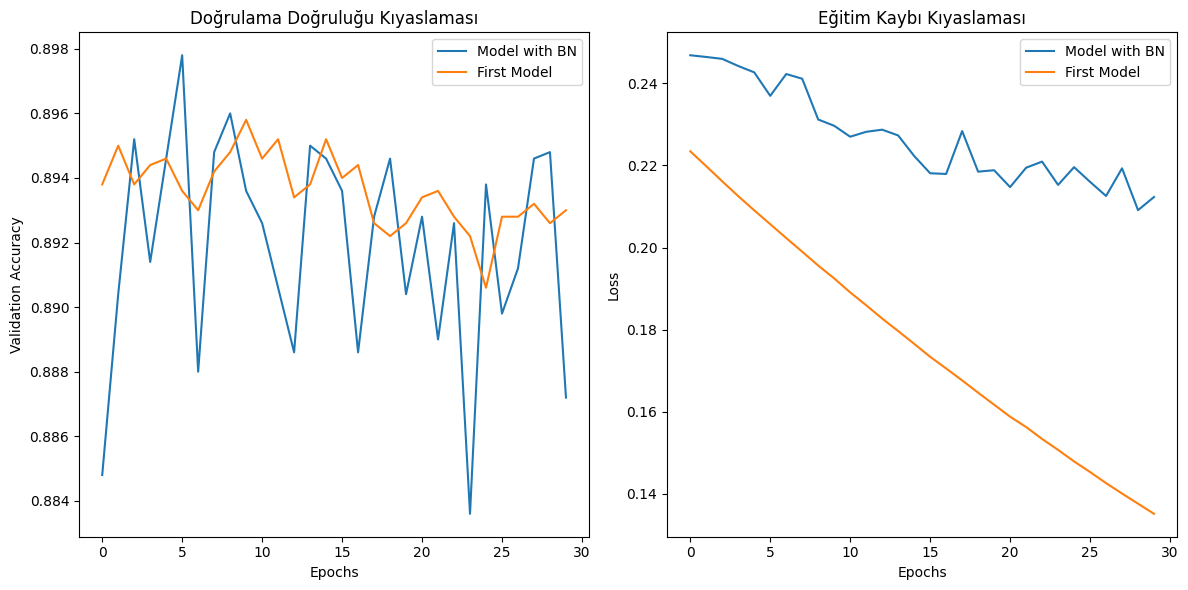

Doğrulama Doğruluğu Sonuçları:
Model with BN - En Son Doğrulama Doğruluğu: 0.8871999979019165
First Model - En Son Doğrulama Doğruluğu: 0.8930000066757202

Eğitim Kaybı Sonuçları:
Model with BN - En Son Kaybı: 0.2123139351606369
First Model - En Son Kaybı: 0.13512012362480164


In [46]:
# Eğitim ve doğrulama doğruluğu grafiği
plt.figure(figsize=(12, 6))

# Doğrulama doğruluğu grafiği
plt.subplot(1, 2, 1)
plt.plot(model_with_bn_history['val_accuracy'], label='Model with BN')
plt.plot(first_model_history['val_accuracy'], label='First Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Doğrulama Doğruluğu Kıyaslaması')
plt.legend()

# Eğitim kaybı grafiği
plt.subplot(1, 2, 2)
plt.plot(model_with_bn_history['loss'], label='Model with BN')
plt.plot(first_model_history['loss'], label='First Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Eğitim Kaybı Kıyaslaması')
plt.legend()

plt.tight_layout()
plt.show()

print("Doğrulama Doğruluğu Sonuçları:")
print(f"Model with BN - En Son Doğrulama Doğruluğu: {model_with_bn_history['val_accuracy'][-1]}")
print(f"First Model - En Son Doğrulama Doğruluğu: {first_model_history['val_accuracy'][-1]}")

print("\nEğitim Kaybı Sonuçları:")
print(f"Model with BN - En Son Kaybı: {model_with_bn_history['loss'][-1]}")
print(f"First Model - En Son Kaybı: {first_model_history['loss'][-1]}")

**Sonuçların Yorumlayalım**

Model with BN için son doğrulama doğruluğu 0.8872 olarak kaydedildi. Bu, modelin doğrulama seti üzerinde oldukça iyi bir performans gösterdiğini gösteriyor. Ancak, diğer modele göre bir miktar daha düşük.

First Model için son doğrulama doğruluğu 0.8930 olarak kaydedildi. Bu model, Batch Normalization eklenmeden önce biraz daha yüksek doğrulama doğruluğu elde etti. Bu, modelin genel performansının Batch Normalization eklemeden daha iyi olduğunu düşündürse de, daha detaylı analizler gerektiriyor.

Model with BN ile  Son eğitim kaybı 0.2123 olarak kaydedildi. Bu, Batch Normalization eklemiş olmamıza rağmen modelin eğitim sırasında kaybın bir miktar yüksek olduğunu gösteriyor. Ancak, bu modelin doğrulama doğruluğunun bir miktar düşük olması, overfitting'i önlemek adına Batch Normalization ve Dropout’un etkili bir şekilde kullanıldığını gösterebilir.

First Modelin son eğitim kaybı 0.1351 olarak kaydedildi. Bu modelin kaybı daha düşük, ancak doğrulama doğruluğunda daha düşük bir performans sergileyerek overfitting'e eğilim gösterebilir. Kaybın düşük olması, modelin eğitim setine çok iyi uyduğunu ancak genel doğrulama setinde sınırlı bir genellenebilirlik gösterdiğini ima ediyor olabilir.

İki model arasındaki performans farkı, Batch Normalization eklemenin doğrulama doğruluğunu biraz düşürse de, genel modelin overfitting'e karşı daha dayanıklı hale gelmesine katkı sağladığını gösteriyor. Eğitim kaybının yüksekliği, modelin eğitim sürecinde daha yavaş düzeldiğini ancak daha stabil bir doğrulama doğruluğu sağladığını bize düşündürmekte.

**Başka Neler Yapılabilir?**

Modelin hiperparametrelerini (öğrenme hızı, batch size, epoch sayısı vb.) optimize etmek, doğrulama doğruluğunu artırabilir. Grid Search ya da Random Search gibi tekniklerle hiperparametre optimizasyonu yapılabilir.
Daha derin ağ yapıları (daha fazla katman, daha fazla nöron) eklemek, modelin daha karmaşık verileri öğrenmesine yardımcı olabilir. Ancak, daha derin ağlar overfitting riskini de artırabilir, bu nedenle dikkatli olunmalıdır

Veri Augmentasyon yapılabilir. Eğitim verisini artırmak için veri augmentasyonu teknikleri (örneğin, resim döndürme, çevirme, zoom, vb.) kullanılabilir. Bu, modelin genellenebilirliğini artırabilir.
Veri setinde hatalı, eksik veya uyumsuz veriler varsa, bu verilerin temizlenmesi veya düzeltilmesi modelin başarısını artırabilir.

Ağırlıkların büyüklüğünü sınırlamak için L2 regularization uygulanabilir. Bu, overfitting'i engellemeye yardımcı olabilir.
Modelin erken aşamalarda aşırı öğrenmesini engellemek için early stopping (erken durdurma) tekniği uygulanabilir. Bu, doğrulama kaybı artmaya başladığında modelin eğitiminin sonlandırılmasını sağlar

Başka model mimarileri veya daha gelişmiş modeller (örneğin, Transfer Learning veya pre-trained modeller) deneyebiliriz.

Daha fazla epoch sayısı ile eğitim yapmak, modelin doğruluğunu artırabilir. Ancak önemli aşırı öğrenme (overfitting) ile karşılaşmamaktır.

Dropout oranını değiştirerek daha iyi sonuçlar alınabiliriz.
Batch normalization parametrelerini (örneğin momentum, epsilon gibi) optimize etmek modelin eğitim sürecini hızlandırabilir ve doğrulama doğruluğunu artırabilirdi

-----------------------------------------

**Modelin Sınıflandırma Sonuçları**

In [48]:
# Modelin tahminleri
y_pred = model_with_bn.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [49]:
# y_pred'yi sınıf tahminlerine dönüştür
y_pred = np.argmax(y_pred, axis=1)

In [50]:
# Doğru ve yanlış tahmin edilen örnekleri kontrol et
correct_indices = np.nonzero(y_pred == y_test)[0]  # Doğru tahminlerin indeksleri
incorrect_indices = np.nonzero(y_pred != y_test)[0]  # Yanlış tahminlerin indeksleri

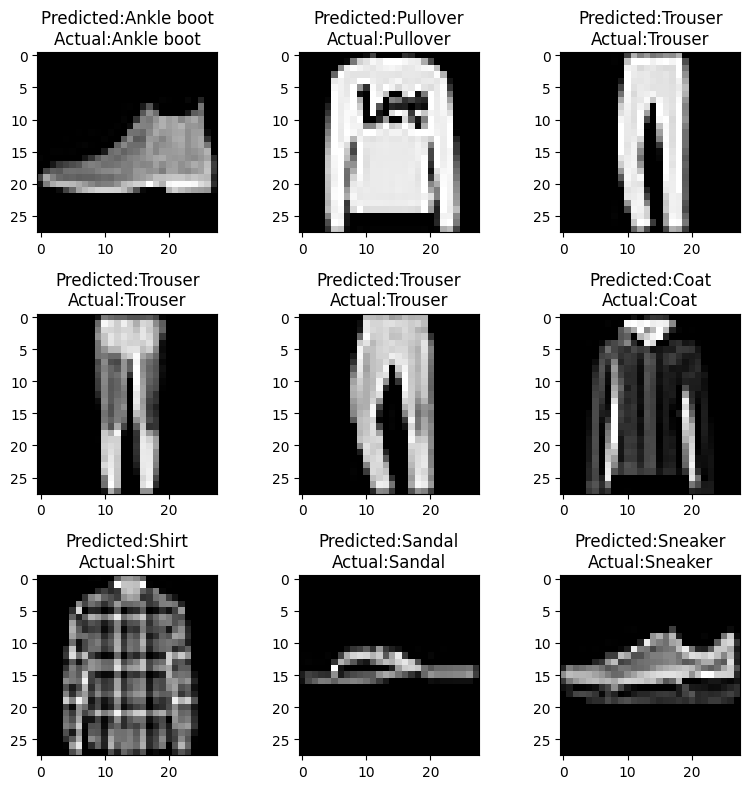

In [51]:
# Doğru tahmin edilen ilk 9 örneği görselleştirme
plt.figure(figsize=(8,8))

for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # Görseli 28x28 boyutlarında yeniden şekillendir
    plt.title("Predicted:{}\nActual:{}".format(class_names[y_pred[correct]], class_names[y_test[correct]]))  # Tahmin edilen ve gerçek sınıfı başlık olarak ekle

plt.tight_layout()  # Alt grafiklerin düzenini ayarla

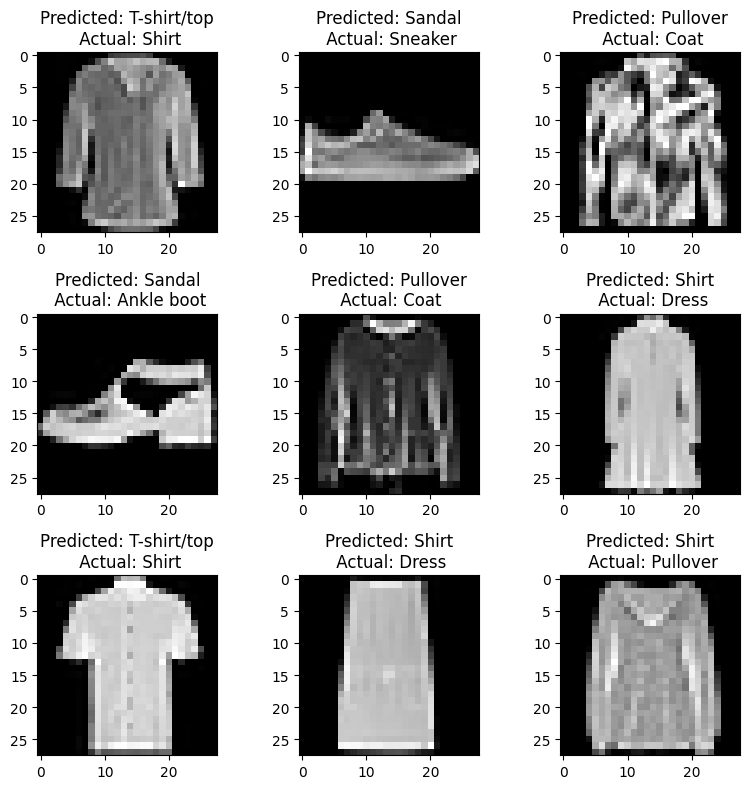

In [52]:
# Yanlış tahmin edilen ilk 9 örneği görselleştirme
plt.figure(figsize=(8,8))

for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')  # Görseli 28x28 boyutlarında yeniden şekillendir
    plt.title("Predicted: {}\n Actual: {}".format(class_names[y_pred[incorrect]], class_names[y_test[incorrect]]))  # Tahmin edilen ve gerçek sınıfı başlık olarak ekle

plt.tight_layout()  # Alt grafiklerin düzenini ayarla

In [56]:
target_names = [class_names[x] for x in range(0,10)]

In [57]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

# Modelin test seti üzerinde tahminler yapması
y_pred = model_with_bn.predict(X_test)

# y_pred'yi sınıf tahminlerine dönüştür
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix oluşturuluyor
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=target_names, columns=target_names)

# Satır ve sütun başlıkları belirleniyor
matrix.index.name = 'Predicted'
matrix.columns.name = 'Actual'

# Confusion matrix'i göster
matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Actual,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Predicted,,,,,,,,,,
T-shirt/top,866,2,19,25,3,3,74,0,8,0
Trouser,6,973,1,14,3,0,2,0,1,0
Pullover,20,1,877,15,42,0,42,0,3,0
Dress,27,13,15,882,28,0,31,0,4,0
Coat,1,1,166,33,753,0,44,0,2,0
Sandal,0,0,0,1,0,957,0,25,1,16
Shirt,190,0,123,22,74,0,579,0,12,0
Sneaker,0,0,0,0,0,13,0,967,0,20
Bag,5,2,4,3,2,4,7,3,970,0


**BatchNormalization ve Dropout tekniği  uyguladığımız Modelimizin Sonuçlarını Yorumlayalım:**

Bu modelin sonuçlarına baktığımızda, genel olarak oldukça iyi bir performans sergilediğini söyleyebiliriz. Her sınıfın doğru tahmin oranı yüksek ve yanlış sınıflandırmaların çoğu, benzer kategorilere yapılmış.

"Trouser", "Sneaker" ve "Sandal" sınıflarında çok yüksek doğruluk oranları var. Örneğin, "Trouser" sınıfı %97.3 doğruluğa sahip, bu da modelin bu kategoriyi çok iyi ayırt ettiğini gösteriyor."Shirt" ve "T-shirt/top" gibi sınıflarda ise yanlış sınıflandırmalar görülüyor. Özellikle "Shirt" sınıfında, "T-shirt/top" ile karışmalar olmuş. Model sınıflar arasındaki bazı ince farkları öğrenebilmesi için daha fazla veri ile eğitilebilir
"Coat" sınıfı biraz daha fazla yanlış tahmin edilmiş. Ancak, yine de doğru tahmin oranı %75 civarında ve bu da iyi bir seviyede diyebiliriz
Sonuç olarak, model genel olarak güçlü bir performans sergiliyor. **Yanlış sınıflandırmalar, özellikle benzer özelliklere sahip sınıflar arasında meydana gelmiş.** **Modelin doğruluğunu artırmak için, daha fazla çeşitlendirilmiş eğitim verisi veya modelin daha uzun süre eğitilmesi faydalı olabilir.**

**first_model ile tahminleme yapalım**

In [58]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

# Modelin test seti üzerinde tahminler yapması
y_pred = first_model.predict(X_test)

# y_pred'yi sınıf tahminlerine dönüştür
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix oluşturuluyor
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=target_names, columns=target_names)

# Satır ve sütun başlıkları belirleniyor
matrix.index.name = 'Predicted'
matrix.columns.name = 'Actual'

# Confusion matrix'i göster
matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Actual,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Predicted,,,,,,,,,,
T-shirt/top,738,3,48,17,3,2,180,0,9,0
Trouser,4,966,3,19,3,0,5,0,0,0
Pullover,12,0,874,10,59,1,42,0,2,0
Dress,13,5,30,869,40,0,39,0,4,0
Coat,1,1,133,18,786,0,58,0,3,0
Sandal,0,0,0,1,0,969,0,14,1,15
Shirt,67,1,116,25,55,0,729,0,7,0
Sneaker,0,0,0,0,0,28,0,942,0,30
Bag,6,0,10,6,4,3,7,3,961,0


**First Modelin Tahmin Sonuçlarını Değerlendirelim:**

Bu modelin sonuçlarını incelediğimizde, genel olarak çok iyi bir performans sergilediğini görebiliyoruz. Herhangi bir yanlış sınıflandırma olduğunda, yanlış tahminlerin çoğunlukla benzer kategorilere (örneğin, "T-shirt/top" ile "Shirt" veya "Pullover" ile "Dress") yapılmış. Bu da modelin sınıflar arasındaki farkları oldukça iyi ayırt edebildiğini gösteriyor diyebiliriz.

En yüksek doğru tahminler "Trouser", "T-shirt/top" ve "Sneaker" gibi sınıflarda doğru tahminler oldukça yüksek. Örneğin, "Trouser" sınıfının %96.6 doğruluğa sahip olması, modelin bu kategoriyi çok iyi tanıdığını gösteriyor.
"Coat" ve "Pullover" gibi sınıflarda ise yanlış sınıflandırmalar daha fazla. Özellikle "Pullover" sınıfının doğru tahmin oranı %87.4 ile biraz daha düşük. Bunun nedeni, bu tür sınıfların bazen birbirine benzer görsel özelliklere sahip olabilmesi olabilir
En fazla yanlış sınıflandırma, "T-shirt/top" ile "Shirt" ve "Coat" ile "Pullover" arasında yapıldığını görüyoruz. Bu sınıflar arasındaki benzerlikler modelin kafa karışıklığına yol açmış olabilir

Genel olarak, model çoğu kategoriyi doğru bir şekilde tahmin edebiliyor. Ancak, bazı sınıflar arasında daha fazla ayrım yapılması için ek iyileştirmeler yapabiliriz. Bu tür yanlış sınıflandırmaların, modelin daha fazla eğitim verisiyle beslenmesi veya veri ön işleme tekniklerinin geliştirilmesi ile azaltılabiliceğini düşünüyorum

**Yeni bir model denemesi (Ek Deneyler)**

In [59]:
import keras

new_model = keras.models.Sequential([
    #  Görselleri düzleştiriyoruz (28x28 boyutlarındaki görüntüler 1D vektöre dönüştürülür)
    keras.layers.Flatten(input_shape=[28, 28]),  # 28x28 boyutundaki her bir görseli tek boyutlu bir vektöre dönüştürüyoruz

    # İlk gizli katman: 512 nöron ve ReLU aktivasyon fonksiyonu kullanıyoruz
    keras.layers.Dense(512, activation='relu'),  # ReLU: Negatif giriş değerlerini sıfırlayarak pozitif değerleri iletir
    keras.layers.Dropout(0.2),  # Dropout: Aşırı öğrenmeyi (overfitting) engellemek için %20 oranında rastgele nöronları kapatıyoruz
    # İkinci gizli katman: 256 nöron ve ReLU aktivasyon fonksiyonu
    keras.layers.Dense(256, activation='relu'),  # Daha küçük ama güçlü bir gizli katman ekliyoruz
    keras.layers.Dropout(0.2),  # Dropout: Aşırı öğrenmeyi engellemek için
    # Üçüncü gizli katman: 128 nöron ve ReLU aktivasyon fonksiyonu
    keras.layers.Dense(128, activation='relu'), # Daha küçük bir katman, öğrenme süreçlerini dengelemeye yardımcı olur
    keras.layers.Dropout(0.2),
    # Çıktı katmanı: 10 nöron (sınıf sayısı) ve softmax aktivasyon fonksiyonu
    keras.layers.Dense(10, activation='softmax')  # Softmax fonksiyonu: Sınıfların olasılıklarını hesaplar
])

# Modeli derleyelim
new_model.compile(loss='sparse_categorical_crossentropy',  # Kategorik çapraz entropi kaybı (sınıflandırma için yaygın bir kayıp fonksiyonu)
              optimizer='adam',  # Adam optimizasyon algoritması, hızlı ve etkili bir şekilde öğrenme sağlar
              metrics=['accuracy'])  # Model doğruluğunu izlemek için doğruluk metriklerini kullanıyoruz

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
new_history = new_model.fit(X_train, y_train,
                    epochs=25,  # Kaç epokta eğitileceğini belirtiyoruz
                    batch_size=128,  # Batch size (bir seferde kaç örnekle çalışılacağı)
                    validation_data=(X_test, y_test),  # Test verisi ile doğrulama
                    verbose=1)  # Eğitim sırasında detayları görmek için

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7165 - loss: 0.7924 - val_accuracy: 0.8435 - val_loss: 0.4300
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8458 - loss: 0.4270 - val_accuracy: 0.8531 - val_loss: 0.3997
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8584 - loss: 0.3836 - val_accuracy: 0.8635 - val_loss: 0.3776
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8705 - loss: 0.3527 - val_accuracy: 0.8658 - val_loss: 0.3684
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8760 - loss: 0.3371 - val_accuracy: 0.8668 - val_loss: 0.3587
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8820 - loss: 0.3213 - val_accuracy: 0.8727 - val_loss: 0.3551
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8839 - loss: 0.3099 - val_accuracy: 0.8786 - val_loss: 0.3414
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8909 - loss: 0.2966 - v

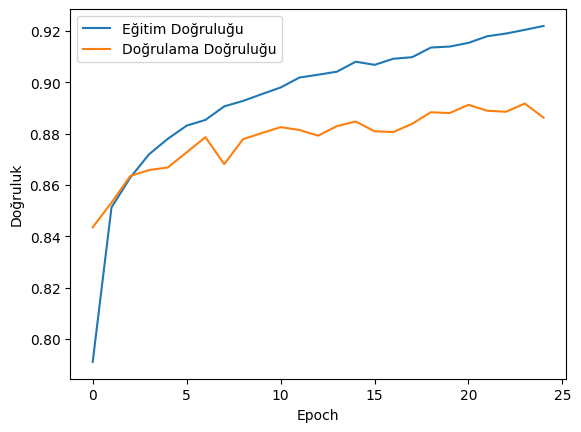

In [61]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğunu çizelim
plt.plot(new_history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(new_history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


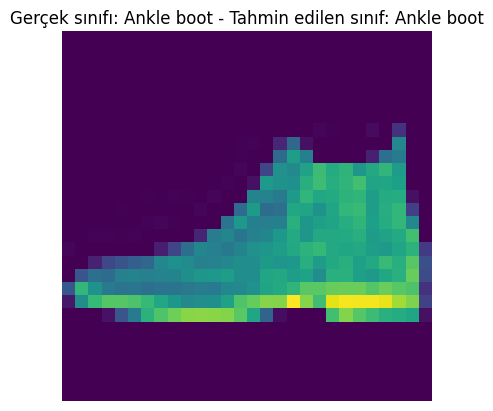

In [66]:
import numpy as np

# Test verisinde tahminler yapalım
y_pred = new_model.predict(X_test)

# Sınıf tahminlerini alın (argmax ile)
y_pred_classes = np.argmax(y_pred, axis=1)

# İlk doğru tahmin edilen örneği alalım
correct_indices = np.where(y_pred_classes == y_test)[0]
idx = correct_indices[0]  # İlk doğru tahmin edilen örneği al

# Görselleştirelim
plt.imshow(X_test[idx].reshape(28, 28))  # 28x28 boyutunda görsel
plt.title(f"Gerçek sınıfı: {class_names[y_test[idx]]} - Tahmin edilen sınıf: {class_names[y_pred_classes[idx]]}")
plt.axis("off")  # Eksenleri kapat
plt.show()
